!pip install tellurium

In [154]:
import tellurium as te
import matplotlib.pyplot as plt

In [156]:

antimony_model_A = """
model *inhalation_A_art_ven()

#Created: Aude Ratier, October 2025
#Checked:

#------------------------
# Compartment
#------------------------
  compartment Air; Air = Valveolar
  compartment Arterial; Arterial = Arterial_volume
  compartment Venous; Venous = Venous_volume
  compartment RestofBody; RestofBody = Vrestbody

#------------------------
# Species
#------------------------
  substanceOnly species Aair in Air
  substanceOnly species Aart in Arterial
  substanceOnly species Aven in Venous
   substanceOnly species Arest in RestofBody

#------------------------
# Reactions / Transfers
#------------------------
 Aair -> Aart;      Falv*Cinh*Fabs; 
 Aart -> Aair;      Falv*Cart/PCAir;

 Aart -> Arest;     Frestbody*Cart; 
 Arest -> Aven ;    Frestbody*Crest/k_restbody_blood;

 Aven -> Aart;      CO*Cven;

 
#------------------------
# Initial conditions
#------------------------
  Aair = 0; 
  Aair has MicroGM;
  Arest = 0;
  Arest has MicroGM;
  Aart = 0;
  Aart has MicroGM;
  Aven = 0;
  Aven has MicroGM;


  // Compartment initializations:
  Cinh = 0; # concentration inhaled [µg/L] 
  Cinh has MicroGM_PER_L;
 #------------------------
# Concentrations
#------------------------
Cinh := Aair / Valveolar
Cart := Aart / Arterial_volume
Cven := Aven / Venous_volume
Crest  := Arest  / RestofBody

#------------------------
# Parameters
#------------------------

# Body size & base volumes
#------------------------

  BW = 70; # body weight [kg]
  BW has KiloGM;

  scVBlood = 0.074; # blood volume as a fraction of body weight [L/kg] (Quindroit et al., 2019)
  scVBlood has L_PER_KiloGM;

  Frestbody = 0.96-scVBlood; # rest of body volume as a fraction of body weight [L/kg] (supposed)
  Frestbody has L_PER_KiloGM;

  Vblood := BW*scVBlood;  # blood volume [L]
  Vblood has L;

  Vrestbody := BW*Frestbody; # rest of body volume [L]
  Vrestbody has L;

  Arterial_volume := Vblood/3; # arterial blood volume [L]
  Arterial_volume has L;

  Venous_volume := Vblood- Arterial_volume; # venous blood volume [L]
  Venous_volume has L;

  scValv = 0.03 # Alveolar volume as fraction of body weight (L)
  scValv has L_PER_KiloGM;

  Valveolar := BW*scValv;  # alveolar volume [L]
  Valveolar has L;

# Plasma Flows
#------------------------
  CO = 12.5*BW^0.75;  # cardiac output as function of body weight [L/h]
  CO has L_PER_HR;

  FQrestbody = CO;  # blood flow to rest-of-body [L/h]
  FQrestbody has L_PER_HR;

  Falv = 210; #Alveolar ventilation rate [L/h]
  Falv has L_PER_HR;


#------------------------
# Chemicals
#------------------------

  Fabs = 0.3; # absorbed fraction [-]
  Fabs has UNITLESS;

  k_restbody_blood = 0.5; # partition coefficient rest of body to blood [-]
  k_restbody_blood has UNITLESS;

  PCAir = 2000; # partition coefficient blood over air [-]
  PCAir has UNITLESS;


  // Other declarations:
  var Arterial, Venous, RestofBody, CO;
  const Air, BW, scVBlood, Frestbody, FQrestbody, k_restbody_blood, PCAir;
  const Falv, Fabs;

  // Unit definitions:
  unit MicroGM = 1e-6 gram;
  unit HR = 3600 second;
  unit L = litre;
  unit KiloGM = 1e3 gram;
  unit L_PER_KiloGM = litre / 1e3 gram;
  unit L_PER_HR_PER_KiloGM0P75 = litre / (3600 second * (1e3 gram)^-0);
  unit UNITLESS = dimensionless;
  unit L_PER_HR = litre / 3600 second;
  unit volume = L;
  unit substance = MicroGM;
  unit extent = MicroGM;
  unit time_unit = HR;
  unit MicroGM_per_L = 1e-6 gram / litre;


end

"""

# Charger le modèle
r = te.loada(antimony_model_A)

# Exporter en SBML
sbml_str = r.getSBML()

# Sauvegarder dans un fichier
with open("inhalation_blood_A.xml", "w") as f:
    f.write(sbml_str)

print("✅ Fichier SBML généré : inhalation_blood_A.xml")

✅ Fichier SBML généré : inhalation_blood_A.xml


In [158]:
# Load and simulate
r = te.loada(antimony_model_A)
r.getGlobalParameterIds()

['Falv',
 'Fabs',
 'PCAir',
 'Frestbody',
 'k_restbody_blood',
 'CO',
 'BW',
 'scVBlood',
 'scValv',
 'FQrestbody',
 'Valveolar',
 'Arterial_volume',
 'Venous_volume',
 'Vrestbody',
 'Cinh',
 'Cart',
 'Crest',
 'Cven',
 'Vblood']

In [160]:
print(f"Aair={r.Aair}, Art={r.Aart}, Aven={r.Aven}, Arest={r.Arest}")
print(f"Vrest={getattr(r, 'Vrest', 'Non défini')}")
print(f"Air={getattr(r, 'Air', 'Non défini')}, Art={getattr(r, 'Art', 'Non défini')}, Ven={getattr(r, 'Ven', 'Non défini')}")
print(f"Fabs={r.Fabs}, PCAir={r.PCAir}, Falv={r.Falv}, BW={r.BW}")

Aair=0.0, Art=0.0, Aven=0.0, Arest=0.0
Vrest=Non défini
Air=2.1, Art=Non défini, Ven=Non défini
Fabs=0.3, PCAir=2000.0, Falv=210.0, BW=70.0


In [162]:
print(hasattr(r, 'Vrest'))

False


In [183]:
# Update for chemcial parameters
r.Fabs = 0.3
r.PCAir = 2000
# Change the initial quantity in air (here 4.97e-05 µg) / single exposure
r.Aair = 4.97e-05
r.Falv = 90 #1y-old
r.BW = 12 #1y-old
simulation = r.simulate(0, 7, 300)

In [166]:
# Mass balance (Amounts)
air_mass = simulation[:, 1] * r.Aair
art_mass = simulation[:, 2] * r.Aart
ven_mass = simulation[:, 3] * r.Aven
rest_mass = simulation[:, 4] * r.Arest

total_mass =  art_mass + ven_mass + rest_mass + air_mass 

MB_check = air_mass - art_mass - ven_mass - rest_mass 
MB_check

[ 4.73372560e-14 -2.73873566e-11 -3.04171093e-11 -2.93617392e-11
 -2.77107046e-11 -2.60573021e-11 -2.44968266e-11 -2.30393185e-11
 -2.16805775e-11 -2.04143563e-11 -1.92344314e-11 -1.81349350e-11
 -1.71103865e-11 -1.61556769e-11 -1.52660455e-11 -1.44370573e-11
 -1.36645788e-11 -1.29447574e-11 -1.22740037e-11 -1.16489730e-11
 -1.10665486e-11 -1.05238243e-11 -1.00180943e-11 -9.54683864e-12
 -9.10770851e-12 -8.69851407e-12 -8.31721407e-12 -7.96190573e-12
 -7.63081681e-12 -7.32229682e-12 -7.03480772e-12 -6.76691692e-12
 -6.51728756e-12 -6.28467737e-12 -6.06792223e-12 -5.86594515e-12
 -5.67773370e-12 -5.50235303e-12 -5.33892520e-12 -5.18663783e-12
 -5.04473009e-12 -4.91249613e-12 -4.78927550e-12 -4.67445513e-12
 -4.56746123e-12 -4.46776123e-12 -4.37485700e-12 -4.28828577e-12
 -4.20761545e-12 -4.13244402e-12 -4.06239658e-12 -3.99712397e-12
 -3.93630075e-12 -3.87962360e-12 -3.82680998e-12 -3.77759638e-12
 -3.73173755e-12 -3.68900458e-12 -3.64918461e-12 -3.61207886e-12
 -3.57750254e-12 -3.54528

In [168]:
r.timeCourseSelections

import pandas as pd

df = pd.DataFrame(simulation, columns=r.timeCourseSelections)
df.head()  # affiche les 5 premières lignes

# time column is equal to 0

,time,[Aair],[Aart],[Aven],[Arest]
0,0.000000,4.970000e-05,0.000000,0.000000e+00,0.000000e+00
1,0.023411,8.637224e-06,0.000048,5.337152e-11,6.068719e-08
2,0.046823,1.563997e-06,0.000053,1.531026e-10,1.610600e-07
3,0.070234,3.412958e-07,0.000051,2.549156e-10,2.621334e-07
4,0.093645,1.259756e-07,0.000047,3.513169e-10,3.576151e-07


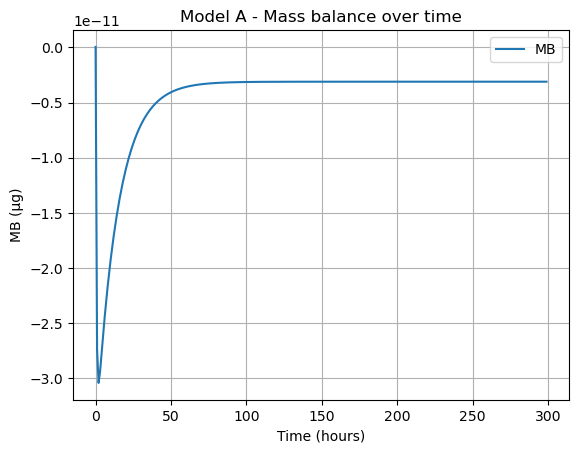

In [170]:
# plot MB
plt.plot(MB_check, label='MB')
plt.xlabel('Time (hours)')
plt.ylabel('MB (µg)')
plt.title('Model A - Mass balance over time')
plt.legend()
plt.grid(True)
plt.show()

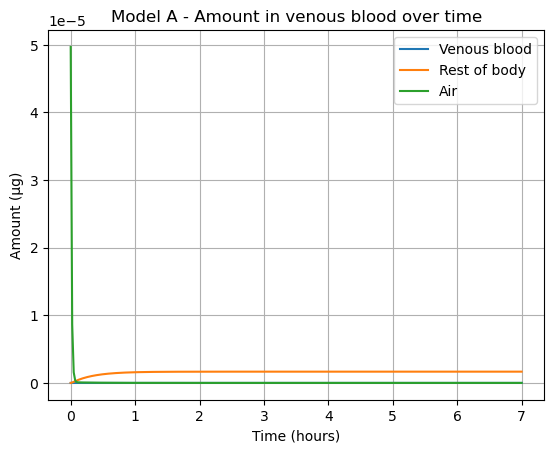

In [172]:
# Plot the amount
plt.plot(simulation[:, 0], simulation[:, 3], label='Venous blood')
plt.plot(simulation[:, 0], simulation[:, 4], label='Rest of body')
plt.plot(simulation[:, 0], simulation[:, 1], label='Air')
plt.xlabel('Time (hours)')
plt.ylabel('Amount (µg)')
plt.title('Model A - Amount in venous blood over time')
plt.legend()
plt.grid(True)
plt.show()

In [173]:
print(r.getFloatingSpeciesIds())

['Aair', 'Aart', 'Aven', 'Arest']


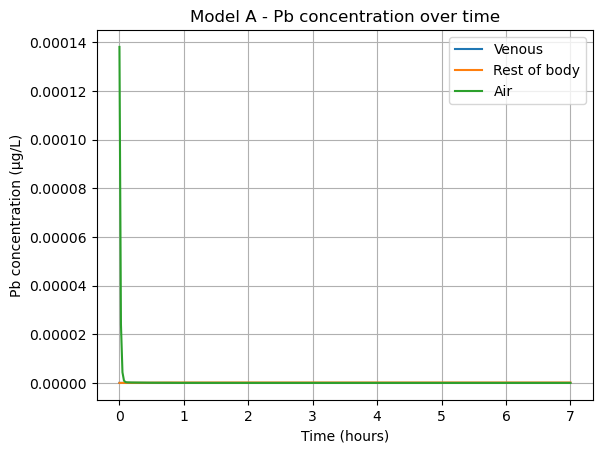

In [176]:
# Plot the concentration in venous blood
plt.plot(simulation[:, 0], simulation[:, 3]/r.Venous_volume, label='Venous')
plt.plot(simulation[:, 0], simulation[:, 4]/r.Vrestbody, label='Rest of body')
plt.plot(simulation[:, 0], simulation[:, 1]/r.Valveolar, label='Air')
plt.xlabel('Time (hours)')
plt.ylabel('Pb concentration (µg/L)')
plt.title('Model A - Pb concentration over time')
plt.legend()
plt.grid(True)
plt.show()

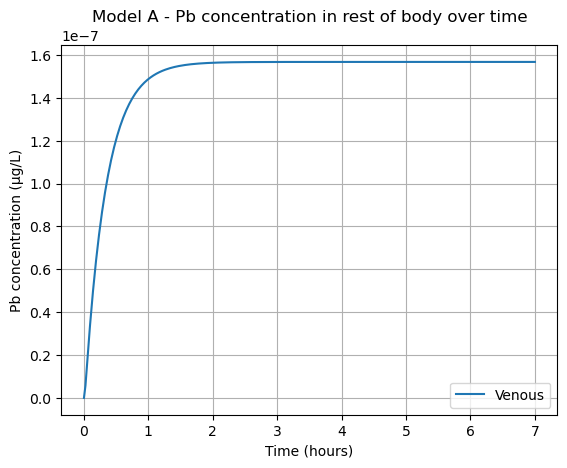

In [178]:
# Plot the concentration in rest of body
plt.plot(simulation[:, 0], simulation[:, 4]/r.Vrestbody, label='Venous')
plt.xlabel('Time (hours)')
plt.ylabel('Pb concentration (µg/L)')
plt.title('Model A - Pb concentration in rest of body over time')
plt.legend()
plt.grid(True)
plt.show()